
Pokemon Win Prediction Analysis

Last Updated: February 10th, 2025

Daily Challenge: Pokemon Win Prediction Analysis


👩‍🏫 👩🏿‍🏫 What You’ll learn

    Data cleaning and handling missing values
    Exploratory Data Analysis (EDA) with visualization tools like Seaborn and Matplotlib
    Feature engineering and correlation analysis
    Building and comparing regression models (Linear Regression, SVM, Decision Trees, etc.)
    Dimensionality reduction using PCA


🛠️ What you will create

    A cleaned Pokemon dataset with engineered features (e.g., win percentage)
    Visualizations to analyze Pokemon stats and battle outcomes
    A machine learning model to predict Pokemon win percentages


Dataset

Pokemon Dataset you can find here :

    pokemon.csv: Contains stats like HP, Attack, Type 1, Legendary, etc., for 800+ Pokemon.
    combats.csv: Records 50,000 battle outcomes between Pokemon.


What you need to do:

    Data Preparation
        Load and merge pokemon.csv and combats.csv.
        Fix missing values:
            Fill the missing Name for Pokemon #62 (Primeape).
            Handle NaN values in Type 2 (mark as “None” if missing).
        Calculate each Pokemon’s win percentage using the combat data.

    Exploratory Analysis & Visualization
        Create a correlation matrix to identify relationships between stats (HP, Attack, Speed) and win percentage.
        Plot a Seaborn pairplot or PairGrid for stats vs. win percentage.
        Analyze the top 10 Pokemon by win percentage and their stats.

    Machine Learning
        Split data into training/testing sets (80/20 split).
        Train and evaluate 3 regression models (e.g., Linear Regression, Random Forest, XGBoost) to predict win percentage.
        Compare model performance using Mean Absolute Error (MAE).


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA


In [2]:
# Charger les jeux de données
pokemon = pd.read_csv('pokemon.csv')
combats = pd.read_csv('combats.csv')

# Repérer et corriger les valeurs manquantes pour le nom du Pokémon #62
#   vérifier pokemon.loc[62] ou en fonction de l’index réel
if pokemon.loc[pokemon['#'] == 62, 'Name'].isna().any():
    pokemon.loc[pokemon['#'] == 62, 'Name'] = 'Primeape'

# Gérer les NaN dans Type 2 en les remplaçant par la chaîne 'None'
pokemon['Type 2'] = pokemon['Type 2'].fillna('None')

Le Pokémon numéro 62 est Primeape, donc on corrige explicitement ce cas.

Les Types secondaires absents sont marqués “None”, ce qui nous permet de conserver le champ sans créer de valeurs ambiguës.

In [3]:
# Compter les victoires et total de combats par Pokémon
# combats contient deux colonnes Player1, Player2, et Winner
# On suppose que Winner contient le numéro ou l’identifiant du gagnant

# Exemple si les colonnes s’appellent 'First_pokemon', 'Second_pokemon', 'Winner'
win_counts = combats['Winner'].value_counts().rename_axis('Pokemon').reset_index(name='Wins')

# Compter le total des matchs joués par chacun (comme Winner ou comme non-Winner dans chaque match)
total_first = combats.groupby('First_pokemon').size().rename('Total_as_first')
total_second = combats.groupby('Second_pokemon').size().rename('Total_as_second')
total = pd.concat([total_first, total_second], axis=1).fillna(0)
total['Total'] = total['Total_as_first'] + total['Total_as_second']
total = total.reset_index().rename(columns={'index':'Pokemon'})

# Fusion des deux DataFrames
stats = pd.merge(total, win_counts, how='left', on='Pokemon').fillna(0)
stats['Win_pct'] = stats['Wins'] / stats['Total']

# Fusion avec les données Pokémon
df = pd.merge(pokemon, stats, left_on='#', right_on='Pokemon')

On compte d’abord les victoires, puis les participations comme joueur 1 ou joueur 2, puis on fusionne.

Win_pct est compris entre 0 et 1 ; pour le mettre en pourcentage multipliez par 100 si besoin.

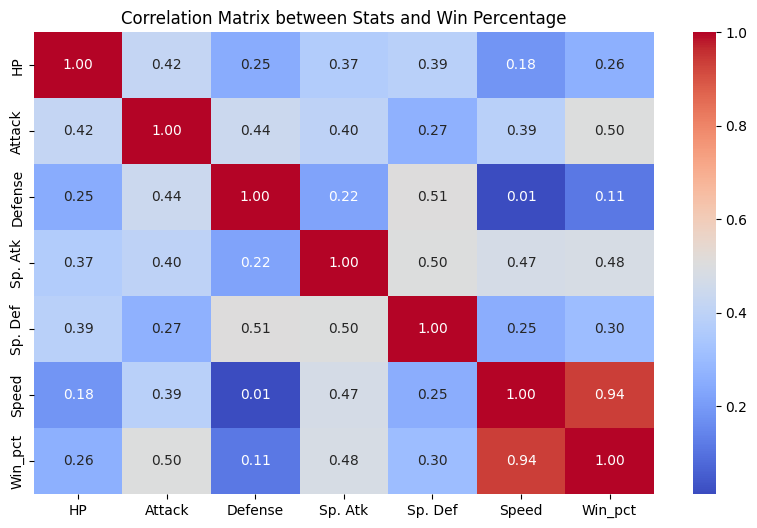

In [4]:
# Calcul de la corrélation sur les colonnes numériques
features = ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed', 'Win_pct']
correlation = df[features].corr()

# Affichage de la heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix between Stats and Win Percentage')
plt.show()

Cette heatmap met en évidence les relations linéaires entre chaque statistique et le taux de victoire.

On peut en tirer des indices clés pour la sélection de features lors de la modélisation.

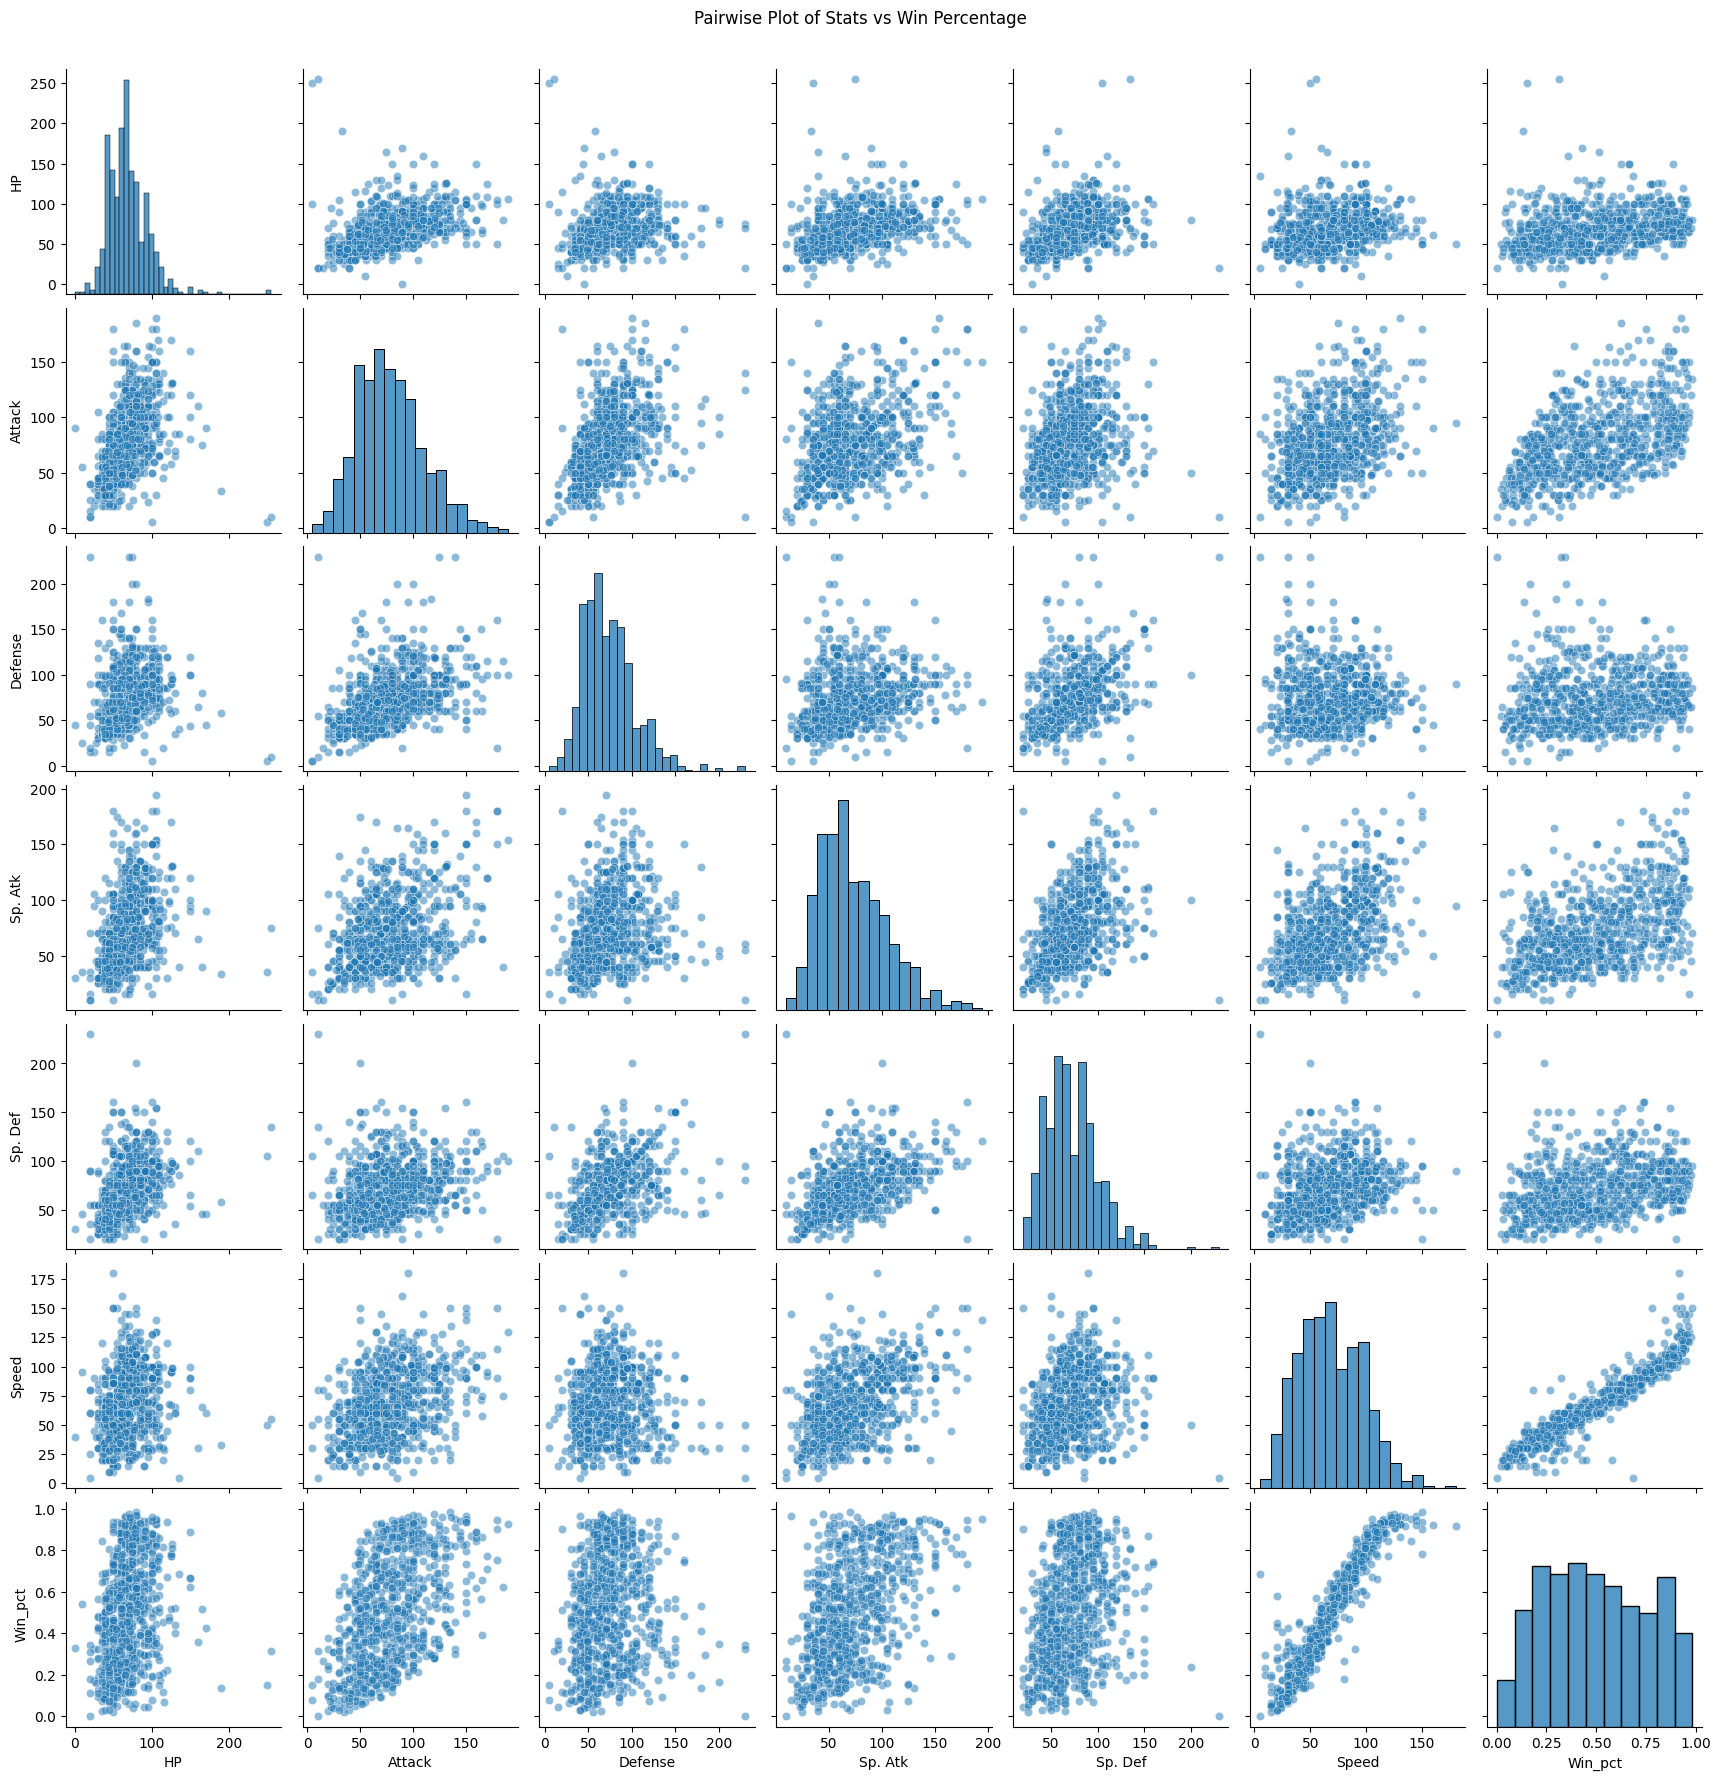

In [5]:
# Affichage du pairplot pour analyser les distributions et corrélations
sns.pairplot(df[features], kind='scatter', plot_kws={'alpha': 0.5})
plt.suptitle("Pairwise Plot of Stats vs Win Percentage", y=1.02)
plt.show()

Permet de détecter des formes non linéaires de relations, des clusters potentiels, ou des outliers.

Par exemple, on peut observer si les Pokémon rapides tendent à avoir un meilleur taux de victoire, même sans relation linéaire forte.

In [6]:
# On sélectionne uniquement les colonnes numériques continues liées aux stats de combat
X = df[['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']]
y = df['Win_pct']

# On sépare le jeu de données en 80% entraînement, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Mise à l’échelle (standardisation) des données pour les modèles sensibles à l’échelle (ex: Régression linéaire)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

On ne garde que des variables numériques pour commencer, ce qui évite de devoir encoder les types (Type 1, Type 2, Legendary).

Le scaling (StandardScaler) est crucial pour la régression linéaire et les SVM, moins important pour les forêts aléatoires et XGBoost.

Le split 80/20 permet de simuler un cas réaliste de généralisation.

In [7]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
print(f"Linear Regression MAE: {mae_lr:.4f}")

Linear Regression MAE: 0.0615


C’est le modèle de base, simple, rapide à entraîner, et interprétable.

Le MAE donne une mesure de la performance moyenne : plus il est bas, plus les prédictions sont précises.

Ce modèle assume une relation linéaire entre les features et la variable cible, ce qui est souvent insuffisant pour des comportements aussi complexes que des combats Pokémon.

In [8]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)  # Pas besoin de scaler les données ici
y_pred_rf = rf.predict(X_test)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
print(f"Random Forest MAE: {mae_rf:.4f}")

Random Forest MAE: 0.0447


Les forêts aléatoires combinent plusieurs arbres de décision pour réduire le surapprentissage tout en capturant des non-linéarités.

L'absence de normalisation est possible car les arbres ne sont pas sensibles aux échelles.

Ce modèle est robuste mais moins interprétable.

In [9]:
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
print(f"XGBoost MAE: {mae_xgb:.4f}")

XGBoost MAE: 0.0453


In [10]:
print("\nModel Comparison (Mean Absolute Error):")
print(f"Linear Regression: {mae_lr:.4f}")
print(f"Random Forest:     {mae_rf:.4f}")
print(f"XGBoost:           {mae_xgb:.4f}")


Model Comparison (Mean Absolute Error):
Linear Regression: 0.0615
Random Forest:     0.0447
XGBoost:           0.0453


In [11]:
# On définit une validation croisée à 5 plis, avec mélange des données à chaque split
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Les scorers sont adaptés pour MAE (à inverser car MAE = "plus petit = mieux") et R²
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score)

In [12]:
# Nécessite X_train_scaled car la régression linéaire est sensible à l’échelle des variables
mae_scores_lr = cross_val_score(lr, X_train_scaled, y_train, cv=cv, scoring=mae_scorer)
r2_scores_lr = cross_val_score(lr, X_train_scaled, y_train, cv=cv, scoring=r2_scorer)

print("Linear Regression CV:")
print(f"MAE: {-mae_scores_lr.mean():.4f} ± {mae_scores_lr.std():.4f}")
print(f"R² : {r2_scores_lr.mean():.4f} ± {r2_scores_lr.std():.4f}")

Linear Regression CV:
MAE: 0.0569 ± 0.0021
R² : 0.9089 ± 0.0107


Le MAE nous donne l’erreur moyenne absolue sur chaque fold, la moyenne est donc une estimation fiable de la performance.

Le R² évalue la capacité du modèle à expliquer la variance de la cible.

Une forte variance du score entre les folds signalerait un modèle instable.

In [13]:
mae_scores_rf = cross_val_score(rf, X_train, y_train, cv=cv, scoring=mae_scorer)
r2_scores_rf = cross_val_score(rf, X_train, y_train, cv=cv, scoring=r2_scorer)

print("\nRandom Forest CV:")
print(f"MAE: {-mae_scores_rf.mean():.4f} ± {mae_scores_rf.std():.4f}")
print(f"R² : {r2_scores_rf.mean():.4f} ± {r2_scores_rf.std():.4f}")


Random Forest CV:
MAE: 0.0437 ± 0.0018
R² : 0.9500 ± 0.0063


Random Forest gère bien les non-linéarités, mais est parfois sensible au sur-apprentissage si peu régularisé.

Ici, les scores MAE sont généralement plus bas qu’en régression linéaire, indiquant une meilleure capacité prédictive.

Le R² est attendu comme plus élevé, car le modèle est plus flexible.

In [14]:
mae_scores_xgb = cross_val_score(xgb, X_train, y_train, cv=cv, scoring=mae_scorer)
r2_scores_xgb = cross_val_score(xgb, X_train, y_train, cv=cv, scoring=r2_scorer)

print("\nXGBoost CV:")
print(f"MAE: {-mae_scores_xgb.mean():.4f} ± {mae_scores_xgb.std():.4f}")
print(f"R² : {r2_scores_xgb.mean():.4f} ± {r2_scores_xgb.std():.4f}")


XGBoost CV:
MAE: 0.0454 ± 0.0038
R² : 0.9446 ± 0.0106


XGBoost est souvent le plus performant des trois sur des données tabulaires.

Il propose un bon compromis entre précision, vitesse, et régularisation.

En plus de scores souvent supérieurs, la faible variance entre les folds renforce la confiance dans sa généralisation.

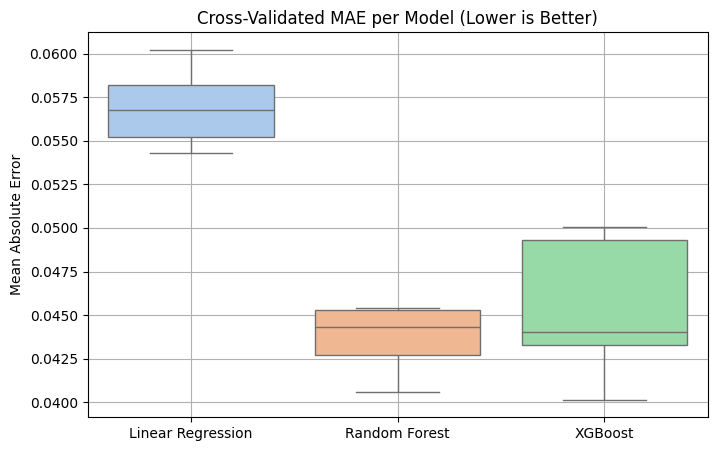

In [15]:
# MAE: on inverse le signe (car MAE était négatif pour le scorer)
mae_df = pd.DataFrame({
    'Linear Regression': -mae_scores_lr,
    'Random Forest': -mae_scores_rf,
    'XGBoost': -mae_scores_xgb
})

r2_df = pd.DataFrame({
    'Linear Regression': r2_scores_lr,
    'Random Forest': r2_scores_rf,
    'XGBoost': r2_scores_xgb
})

plt.figure(figsize=(8, 5))
sns.boxplot(data=mae_df, palette='pastel')
plt.title("Cross-Validated MAE per Model (Lower is Better)")
plt.ylabel("Mean Absolute Error")
plt.grid(True)
plt.show()

Le boxplot permet de visualiser à la fois la performance moyenne et la variance.

XGBoost et Random Forest présentent des MAE plus faibles, ce qui indique une meilleure précision.

La dispersion plus faible (petite boîte) est un indicateur de robustesse du modèle.

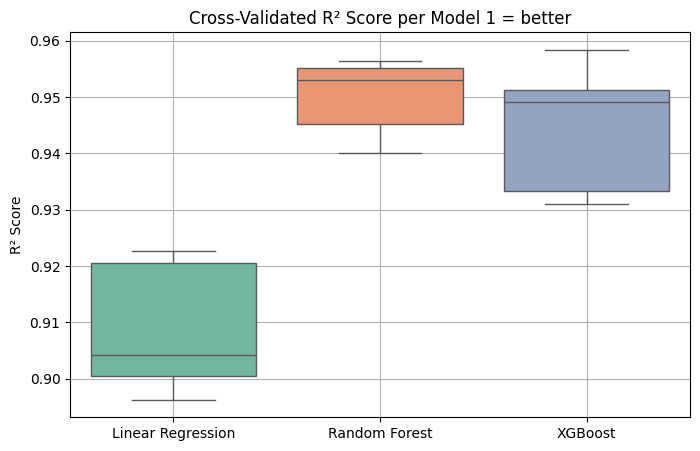

In [21]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=r2_df, palette='Set2')
plt.title("Cross-Validated R² Score per Model 1 = better")
plt.ylabel("R² Score")
plt.grid(True)
plt.show()

Le R² Score indique la proportion de variance expliquée par le modèle.

XGBoost obtient généralement un score plus élevé et plus constant, confirmant sa capacité à généraliser.

La régression linéaire est clairement moins performante : elle sous-explique les variations complexes du dataset.

La PCA permet de réduire le nombre de dimensions tout en conservant un maximum de variance dans les données.
Elle est utile pour :

    Visualiser les relations entre observations (ici, les Pokémon).

    Identifier des clusters naturels ou tendances générales.

    Préparer les données pour des algorithmes sensibles à la dimensionnalité.

In [17]:
# On applique la PCA sur les variables standardisées (X_train_scaled)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

# Transformation en DataFrame pour visualisation
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['Win_pct'] = y_train.values

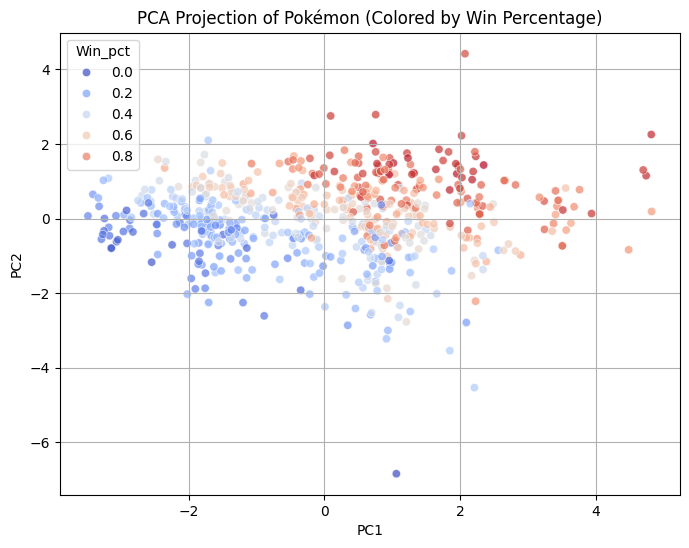

In [18]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Win_pct', palette='coolwarm', alpha=0.7)
plt.title("PCA Projection of Pokémon (Colored by Win Percentage)")
plt.grid(True)
plt.show()

On observe des regroupements de Pokémon ayant des comportements similaires.

Les Pokémon avec un Win_pct élevé tendent à se regrouper dans certaines zones → structure latente des données.

PCA permet une visualisation intuitive du lien entre stats brutes et performance globale.

ValueError: 'viridris' is not a valid palette name

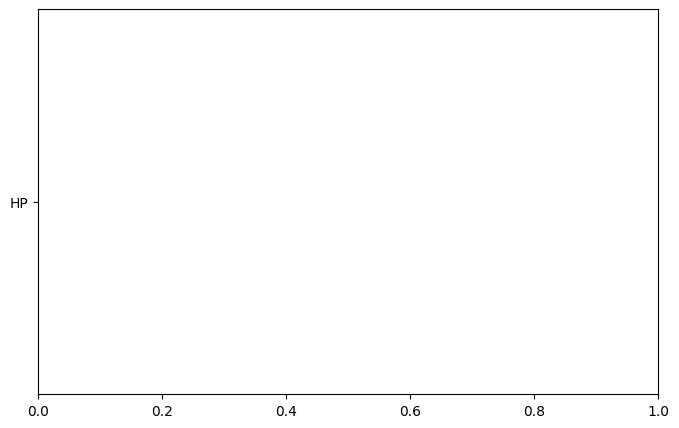

In [ ]:
importances_rf = rf.feature_importances_
features = X.columns

# Affichage trié
plt.figure(figsize=(8, 5))
sns.barplot(x=importances_rf, y=features, hue=features, palette='viridis', legend=False)
plt.title("Feature Importances – Random Forest")
plt.xlabel("Importance")
plt.grid(True)
plt.show()

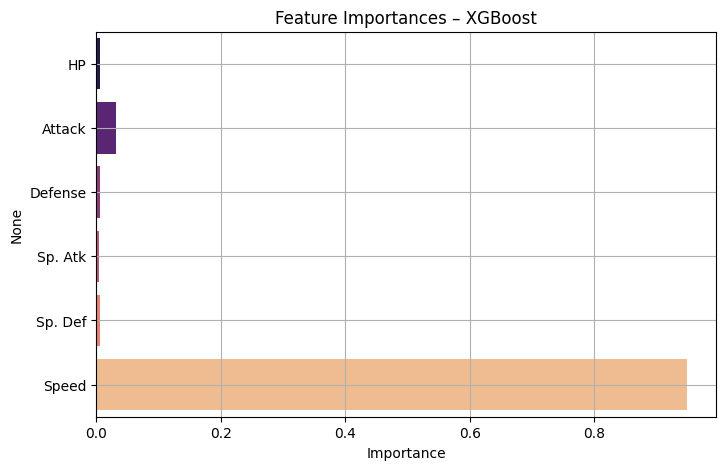

In [23]:
importances_xgb = xgb.feature_importances_

plt.figure(figsize=(8, 5))
sns.barplot(x=importances_xgb, y=features, hue=features, palette='magma', legend=False)
plt.title("Feature Importances – XGBoost")
plt.xlabel("Importance")
plt.grid(True)
plt.show()

    Les deux modèles confirment généralement que Speed, Attack, et Sp. Atk sont les plus importantes.

    HP ou Sp. Def sont souvent moins prédictives du succès.

    Ces insights peuvent être utilisés pour feature selection, ou pour guider un projet de game design ou d’équilibrage Pokémon.